In [71]:
# Use this cell to regroup all your imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')

# 🏆 Le Wagon Kaggle Batch Challenge

<img src='https://github.com/lewagon/data-images/blob/master/ML/kaggle-batch-challenge.png?raw=true' width=600>

🏆 Welcome to your first Kaggle competition!

Your objective is to **submit online an answer** to the open competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

- Fortunately, you have already come across the house dataset in the bootcamp!
- You will be semi-guided up to a **baseline model**
- Only after will you be free to improve & refine your models
- We will approach the problem through **pipelines** (the best practice to take!)

A word on Kaggle:
- Kaggle will rank your submission amongst all participants!
- But don't worry, everyone is publicly removed from the leaderboard after 2 months
- You can make to 10 submissions per day

🧹 Today is the perfect day to practice keeping your long notebook **tidy** 🧹
- "Collapse all headings" from the "command palette" (Cmd + Shift + P)
- Stay idempotent (restart & run all should never crash)
- Name and delete variables carefully

## Setup Kaggle

👉 Create an account on Kaggle if you want to participate in the competition. 

👉 Join the [House Prices Challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) 

👉 Write down your Kaggle `username` the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

**Your whole class will compete as a group against the team of TAs**

## Load

We have already downloaded for you everything from Kaggle into your current notebook folder:
- `train.csv` is your (1460 * 81) training set containing `X` and `y`
- `test.csv` is your (1459 * 80) testing set without the associated target `y` 😈
- `sample_submission.csv` describing the format required to submit your answer
- `data_description.txt` describing all columns

Your goal is to predict the `y_pred` missing from your test set and submit it to discover your test_score & ranking

❓ Load the train dataset in a DataFrame `data` and create your `X` and `y`. Inspect their shape

In [72]:
# YOUR CODE HERE
import pandas as pd
data=pd.read_csv("./data/train.csv")


In [73]:
train_data=data.drop(columns=["Id","SalePrice"])
train_data.shape


(1460, 79)

In [74]:
y=data["SalePrice"]

# 🐣 1. BASELINE

## 1.1 Initial feature overview

80 features is too much to deal with one-by-one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [75]:
# YOUR CODE HERE
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

❓ Store the Series `feat_categorical_nunique` containing the number of **unique values** for each categorical feature in our training set. How many unique categories are there in total ?

In [ ]:
# YOUR CODE HERE
feat_categorical_nunique=len(train_data.drop_duplicates())

In [77]:
feat_categorical_nunique=train_data.select_dtypes(include=object ).nunique()
feat_categorical_nunique

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix `X_preproc` would become pretty big and spare, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with ~50 features max (📚 Read this [rule of thumb](https://datascience.stackexchange.com/a/11480/98300))

We know 2 main strategies to reduce the number of categorical features post-preprocessing:
- **[Remove](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)** features that bring too little explanation to our model. This may require statistical analysis of feature importance 
- **[Ordinally encode](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)** (instead of one-hot-encode) categorical features into integers. However this forces a notion of "order" (1>2>3...) that can be detrimental if not set properly!

❓ Plot the **histogram** of number of unique value per categorical feature. Do you see some quick wins?

<AxesSubplot:>

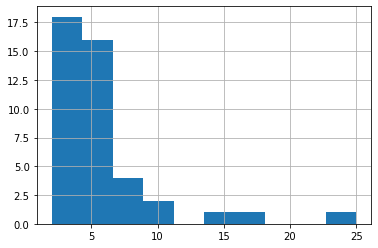

In [78]:
# YOUR CODE HERE
feat_categorical_nunique.hist()

💡 As a starter, what about simply **removing** all features that have **7 unique values or more**, and one-hot-encode every others? Let's keep ordinal encoding and statistical feature selection for the next iteration of our pipeline.

❓ Store features names to OHE in a list `feat_categorical_small` below. How many features will be OHE?

In [79]:
columns=feat_categorical_nunique.index
feat_categorical_nunique.index

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [80]:
# YOUR CODE HERE
feat_categorical_small=[col for col in columns if feat_categorical_nunique[col] < 7]
feat_categorical_small

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'RoofStyle',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleCondition']

In [81]:
# YOUR CODE HERE

🧪 Test your code below (and clear the cell once it passed)

In [82]:
from nbresult import ChallengeResult
result = ChallengeResult('features_overview',
    n=len(feat_categorical_small))
result.write(); print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /Users/shu/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/shu/Desktop/Lewagon/code/shiro101010101/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 1 item

tests/test_features_overview.py::TestFeaturesOverview::test_feat_categorical_small PASSED [100%]

============================== 1 passed in 0.05s ===============================


💯 You can commit your code:

git add tests/features_overview.pickle

git commit -m 'Completed features_overview step'

git push origin master


## 1.2 Baseline pipe

### a) Preprocessing

❓ Let's code the basic preprocessing pipeline described below. Save it under `preproc_baseline`.

For categorical features
- Simple-Impute with most frequent values
- One-Hot-Encode features that have less than 7 unique values to start with
- Drop all others features


As for numerical features
- Simple-Impute with strategy 'mean'
- Min-Max Scale 


<details>
    <summary>ℹ️ Pro tips</summary>

If you are confident, you can try sklearn's shorter syntax `make_pipeline` or `make_column_transformer` instead of the longer syntax `Pipeline` or `ColumnTransformer` if you want to avoid giving names manually to every steps.
</details>

In [83]:
# YOUR CODE HERE
from sklearn import set_config; set_config(display='diagram')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

#categorical features 
#drop default :remainder{‘drop’, ‘passthrough’} or estimator, default=’drop’
cal_transfomer=Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("endocer",OneHotEncoder(handle_unknown="ignore")),
    
])

#numerical features
num_transformer=Pipeline([
    ("imputer",SimpleImputer(strategy="mean")),
    ("scaling",MinMaxScaler())
])


# Preprocessing pipeline
preprocessor=ColumnTransformer([
    ("cal_tr",cal_transfomer,feat_categorical_small),
    ("num_rt",num_transformer,make_column_selector(dtype_include=["int64","float64"]))
])

preproc_baseline=preprocessor
preproc_baseline

ColumnTransformer(transformers=[('cal_tr',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('endocer',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['MSZoning', 'Street', 'Alley', 'LotShape',
                                  'LandContour', 'Utilities', 'LotConfig',
                                  'LandSlope', 'BldgType', 'RoofStyle',
                                  'MasVnrType', 'ExterQual', 'ExterCond',
                                  'Foundation', 'BsmtQual', 'BsmtCond',
                                  'B...posure', 'BsmtFinType1',
                                  'BsmtFinType2', 'Heating', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'KitchenQual',
                                  'FireplaceQu', 'GarageType', 'GarageFinish',
                                  'GarageQual', 'GarageCond', 'PavedDrive', ...]),
                                ('num_rt',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaling', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x17cb842b0>)])

In [84]:
pd.DataFrame(preproc_baseline.fit_transform(train_data)).shape

(1460, 183)

In [85]:
train_data.shape

(1460, 79)

In [86]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [87]:
shape_preproc_baseline=preproc_baseline.fit_transform(train_data).shape

❓ Look at the **shape** of your preprocessed dataframe.

In [88]:
# YOUR CODE HERE

🧪 Test your code below

In [89]:
from nbresult import ChallengeResult
result = ChallengeResult('preproc_baseline',
    shape=shape_preproc_baseline)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /Users/shu/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/shu/Desktop/Lewagon/code/shiro101010101/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 1 item

tests/test_preproc_baseline.py::TestPreprocBaseline::test_shape PASSED   [100%]

============================== 1 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/preproc_baseline.pickle

git commit -m 'Completed preproc_baseline step'

git push origin master


### b) Add estimator

❓ Add a simple Decision Tree model to your `preproc_baseline` and store it to `pipe_baseline` variable.

In [164]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# YOUR CODE HERE
pipe_baseline=Pipeline([
    ("preprocessing",preproc_baseline),
    ("r_tree",RandomForestRegressor())
])

pipe_baseline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cal_tr',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('endocer',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Fou...
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...]),
                                                 ('num_rt',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17cb842b0>)])),
                ('r_tree', RandomForestRegressor())])

In [165]:
pipe_baseline.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('cal_tr',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('endocer',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandContour', 'Utilities', 'LotConfig',
                                     'LandSlope', 'BldgType', 'RoofStyle',
                                     'MasVnrType', 'ExterQual', 'ExterCond',
                                     'Foundation', 'BsmtQual', 'BsmtCond',
                                     'B...posure', 'BsmtFinType1',
                                     'BsmtFinType2', 'Heating', 'HeatingQC',
                                     'CentralAir', 'Electric

### c) Cross-Validate

❓ Read the Kaggle [contest evaluation rules](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) 
- Which performance metric do you need? Is it readily available in sklearn?
- We will need to create our custom `sklearn.metrics.scorer` object so as to pass to any cross-validation or grid search as below


👉 Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` kwarg as below:
```python
cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
```
👉 Create also the negative version `rmsle_neg` which is best when _maximized_. This will come handy later as `GridSearchCV` always tries to _maximize_ a score
```python
GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmse_neg)
```

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [166]:
def root_mean_squared_log_error(y_true, y_pred):
    t = np.array(y_true)
    p = np.array(y_pred)
    log_error = np.log(1+t) - np.log(1+p)
    return ((log_error**2).mean())**0.5

# This is our metric to minimize
rmsle = make_scorer(root_mean_squared_log_error)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * root_mean_squared_log_error(y_true, y_pred))

In [167]:
# outliears and big penalty for the underestimation
# https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a

import numpy as np
from sklearn.metrics import mean_squared_log_error,make_scorer
#not log error
# rmsle=make_scorer(np.sqrt(mean_squared_log_error))

rmsle=make_scorer(mean_squared_log_error,greater_is_better=False)

In [168]:
# OPTION 2 - reuse sklearn "mean_squared_log_error"
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)

In [193]:
pipe_baseline.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(transformers=[('cal_tr',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('endocer',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['MSZoning', 'Street', 'Alley', 'LotShape',
                                     'LandContour', 'Utilities', 'LotConfig',
                                     'LandSlope', 'BldgType', 'RoofStyle',
                                     'MasVnrType', 'ExterQual', 'ExterCond',
                                     'Foundation', 'BsmtQual', 'BsmtCond',
                                     'B...posure', 'BsmtFinType1',
                                     'BsmtFinType2', 'Heating', 'HeatingQC',
                                     'CentralAir', 'Electric

❓5-fold cross_validate your `pipe_baseline` using this metric to get a first glance at your baseline perf.    

Store your mean score as `score_baseline`

In [210]:
# YOUR CODE HERE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_grid={'preprocessing__num_rt__imputer__strategy': ['mean', 'median'],
            'r_tree__n_estimators':[30,100]}

search=RandomizedSearchCV(pipe_baseline,
                          param_grid,
                          cv=5,
                          n_iter=100,
                          scoring=rmsle
                          
                         )
search.fit(train_data,y)

pipe_baseline_tuned=search.best_estimator_
pipe_baseline_tuned

/Users/shu/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cal_tr',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('endocer',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MSZoning', 'Street',
                                                   'Alley', 'LotShape',
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'RoofStyle',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Fou...
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'FireplaceQu', 'GarageType',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PavedDrive', ...]),
                                                 ('num_rt',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaling',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17e9a08e0>)])),
                ('r_tree', RandomForestRegressor(n_estimators=30))])

In [211]:
search.best_params_

{'r_tree__n_estimators': 30,
 'preprocessing__num_rt__imputer__strategy': 'median'}

In [208]:
# X_test = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/houses_test_raw.csv")
# X_test_ids = X_test['Id'] # Keep ids
# X_test = X_test.drop(columns=['Id'])

# # Predict y_pred_baseline
# pipe_baseline.fit(X,y)　？？？ same as the serach.best_estimator??
# y_pred_baseline = pipe_baseline.predict(X_test)
# y_pred_baseline

In [209]:
#model pipe_baseline_tuned with the best prametor from Gridsearch ,
#then apply the model to the cridsearch and clalulate score


from sklearn.model_selection import cross_val_score
score_baseline=cross_val_score(pipe_baseline_tuned, train_data, y, cv=5, scoring=rmsle).mean()
score_baseline

0.14790702522681823

### d) Predict baseline

❓ Predict `y_pred_baseline` from the Kaggle `test.csv` dataset you stored in the `data` folder.

In [185]:
# YOUR CODE HERE
test_data=pd.read_csv("./data/test.csv")
#save ID
test_id=test_data["Id"]
test_id


0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [186]:
# YOUR CODE HERE
test_data=pd.read_csv("./data/test.csv")
#save ID
test_id=test_data["Id"]
test_id

X_test = test_data.drop(columns=['Id'])
X_test 



,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [187]:
y_pred_baseline=search.best_estimator_.predict(X_test)
y_pred_baseline

array([127205.83, 155097.41, 177329.9 , ..., 154847.39, 113719.83,
       226787.79])

In [188]:
# y_pred_baseline["id"]=y_pred_baseline.index
# new_y_pread=y_pred_baseline.reset_index(inplace=True)

In [189]:
y_pred_baseline=pd.concat([test_id,pd.Series(y_pred_baseline,name="SalePrice")],axis=1)

In [190]:
result

❓ Finally, store your CSV ready to be submitted as `submission_baseline.csv` in the `data` folder. Read carefully the Kaggle required format and test it below (you don't need to submit this baseline online for now).

In [191]:
y_pred_baseline.to_csv(r"./data/submission_baseline.csv",index=False,header=True)

🧪 Test your code

In [192]:
from nbresult import ChallengeResult
tmp = pd.read_csv("data/submission_baseline.csv")
result = ChallengeResult('submission_baseline',
    score_baseline = score_baseline,
    submission_shape = tmp.shape,
    submission_columns = list(tmp.columns),
    submission_dtypes = str(list(tmp.dtypes)),
)
result.write()
print(result.check())

============================= test session starts ==============================
platform darwin -- Python 3.8.12, pytest-6.2.5, py-1.10.0, pluggy-1.0.0 -- /Users/shu/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/shu/Desktop/Lewagon/code/shiro101010101/data-challenges/05-ML/07-Ensemble-Methods/01-Houses-Kaggle-Competition
plugins: dash-2.0.0, anyio-3.3.2
collecting ... collected 4 items

tests/test_submission_baseline.py::TestSubmissionBaseline::test_score_baseline PASSED [ 25%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_columns PASSED [ 50%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_dtypes PASSED [ 75%]
tests/test_submission_baseline.py::TestSubmissionBaseline::test_submission_shape PASSED [100%]

============================== 4 passed in 0.21s ===============================


💯 You can commit your code:

git add tests/submission_baseline.pickle

git commit -m 'Completed submission_baselin

# 🏋️‍♀️ 2. ITERATIONS 

🎉 🎉 Congratulation for having fully pipelined a basline model! You will see now how easier it is to iterate and improve performance 🚀

- Your goal is to improve your prediction and submit it by **16h30 max online**
- We suggested you some improvements below: **Pick up your fights** and **incrementally** improve your pipeline as you see fit

**Estimators**

- **Tree-based ensembles (must try today)**: Probably the best suited for many categorical-features problems
- Stacking !
- XGBoost !

**Preprocessing** (once your first ensemble models works)

- Ordinal Encoding of categorical features with a hidden notion of order in their values (e.g. "bad", "average", good")
- Statistical Feature Selection to remove useless features (avoid overfitting and reduce train time)
- Predict log(SalePrice) instead?
- ...

## 2.1 Preprocessing Iteration ♲ 
(**⚠️ come back here only after you have iterated on your estimators on section 2.2)**

⏩ Collapse me if you don't use me!

### a) Ordinal Encoding (1h)

❓ Look at the following feature below. Couldn't it be encoded numerically in a wise manner?
```
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
```

💡 Luckily, the `OrdinalEncoder` and its argument `categories`  allows us to do just that. Check it out below and make sure to understand how this works

In [48]:
# Define specific order for features
from sklearn.preprocessing import OrdinalEncoder
# Note: if you change this order, it will change the output for .transform()
feature_A_sorted_values = ['bad', 'average', 'good'] 
feature_B_sorted_values = ['dirty', 'clean', 'new']

encoder = OrdinalEncoder(
    categories=[
        feature_A_sorted_values,
        feature_B_sorted_values
    ],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Just some random training data
XX = [
    ['good', 'dirty'],
    ['bad', 'new'],
    ['average', 'clean'],
]

encoder.fit(XX)

encoder.transform([
        ['bad', "dirty"],
        ["average", "clean"],
        ['good', 'new'],
        ['bad', 'oooops never seen this label before']
])

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 0., -1.]])

In [62]:
train_data['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [ ]:
train_data['MSZoning']

<AxesSubplot:>

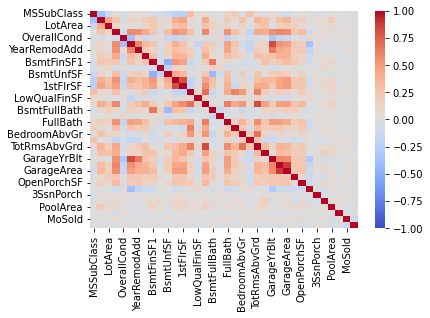

In [135]:
import seaborn as sns
sns.heatmap(train_data.corr(),cmap="coolwarm",vmin=-1,vmax=1)

In [54]:
# YOUR CODE HERE
train_data[feat_categorical_small].columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'BldgType', 'RoofStyle', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleCondition'],
      dtype='object')

In [152]:
from scipy import stats

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor

In [153]:
train_data[feat_categorical_small].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,BldgType,RoofStyle,...,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,1Fam,Gable,...,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,1Fam,Gable,...,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,Normal


---
❓ **Your turn**: split your categorical preprocessor into

- `preproc_ordinal` to ordinally encode **some features** of your choice
- `preproc_nominal` to one hot encode the other ones


<details>
    <summary>Hints</summary>

- You won't be able to avoid hard-coding names and ordered values of features! Be tidy!
- It's a good practice to sort alphabetically your features to avoid bad surprises
</details>

In [154]:
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
    "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
}

feature_ordinal=sorted(feat_ordinal_dict.keys())
feature_ordinal_value_sorted=[feat_ordinal_dict[i] for i in feature_ordinal]
feature_ordinal_value_sorted

[['missing', 'Po', 'Fa', 'TA', 'Gd'],
 ['missing', 'No', 'Mn', 'Av', 'Gd'],
 ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Unf', 'RFn', 'Fin'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
 ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
 ['missing', 'Sev', 'Mod', 'Gtl'],
 ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
 ['missing', 'N', 'P', 'Y'],
 ['missing', 'Fa', 'Gd', 'Ex']]

In [156]:
encoder_ordinal=OrdinalEncoder(categories=feature_ordinal_value_sorted,
                               dtype=np.int64,
                               handle_unknown="use_encoded_value",
                               unknown_value=-1)

preproc_ordinal=make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"),
                              encoder_ordinal,
                              MinMaxScaler())
preproc_ordinal

                              
                              

    

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['missing', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['missing', 'No', 'Mn', 'Av', 'Gd'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Unf', 'LwQ', 'Rec',
                                             'BLQ', 'ALQ', 'GLQ'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Mix', 'FuseP...
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['missing', 'Low', 'Bnk', 'HLS',
                                             'Lvl'],
                                            ['missing', 'Sev', 'Mod', 'Gtl'],
                                            ['missing', 'IR3', 'IR2', 'IR1',
                                             'Reg'],
                                            ['missing', 'N', 'P', 'Y'],
                                            ['missing', 'Fa', 'Gd', 'Ex']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('minmaxscaler', MinMaxScaler())])

In [161]:
feat_numerical = sorted(train_data.select_dtypes(include=["int64", "float64"]).columns)
feat_numerical 

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MasVnrArea',
 'MiscVal',
 'MoSold',
 'OpenPorchSF',
 'OverallCond',
 'OverallQual',
 'PoolArea',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF',
 'YearBuilt',
 'YearRemodAdd',
 'YrSold']

In [224]:
#numerical feature pipe
preproc_numerical=make_pipeline(
KNNImputer(),
MinMaxScaler())
preproc_numerical

Pipeline(steps=[('knnimputer', KNNImputer()), ('minmaxscaler', MinMaxScaler())])

In [225]:
#nominal

feat_nominal=sorted(list(set(train_data.columns)-set(feat_numerical)-set(feature_ordinal)))
feat_nominal


['Alley',
 'BldgType',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'GarageType',
 'Heating',
 'HouseStyle',
 'LotConfig',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'Neighborhood',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities']

In [235]:


#for num feature int,float
preproc_nominal=make_pipeline(
SimpleImputer(strategy='most_frequent'),
OneHotEncoder(handle_unknown="ignore"))
preproc_nominal

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

In [236]:
preproc=make_column_transformer(
    (preproc_numerical,feat_numerical),
    (preproc_nominal,feat_nominal),
    (preproc_ordinal,feature_ordinal),
    remainder="drop"
)
preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
                                  'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
                                  'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
                                  'EnclosedPorch', 'Fireplaces', 'FullBath',
                                  'GarageArea', 'GarageCars', 'GarageYrBlt',
                                  'GrLivArea', 'HalfBath', 'Kitc...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                                  'BsmtFinType2', 'BsmtQual', 'Electrical',
                                  'ExterCond', 'ExterQual', 'Fence',
                                  'FireplaceQu', 'Functional', 'GarageCond',
                                  'GarageFinish', 'GarageQual', 'HeatingQC',
                                  'KitchenQual', 'LandContour', 'LandSlope',
                                  'LotShape', 'PavedDrive', 'PoolQC'])])

In [288]:
from xgboost import XGBRegressor

my_model = RandomForestRegressor()

In [289]:
pipe_3 = make_pipeline(preproc, my_model )
pipe_3 

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('knnimputer',
                                                                                    KNNImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x17f155820>),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(fill_value='missing',...
                                                                    'Foundation',
                                                                    'GarageType',
                                                                    'Heating',
                                                                    'HouseStyle',
                                                                    'LotConfig',
                                                                    'MSZoning',
                                                                    'MasVnrType',
                                                                    'MiscFeature',
                                                                    'Neighborhood',
                                                                    'RoofMatl',
                                                                    'RoofStyle',
                                                                    'SaleCondition',
                                                                    'SaleType',
                                                                    'Street',
                                                                    'Utilities'])])),
                                 ('selectpercentile',
                                  SelectPercentile(percentile=25,
                                                   score_func=<function mutual_info_regression at 0x17fc4b040>))])),
                ('randomforestregressor', RandomForestRegressor())])

In [291]:
pipe_3.fit(train_data,y)
y_read3=pipe_3.predict(X_test)

In [292]:


## pipeline2+ XG
test_data=pd.read_csv("./data/test.csv")
#save ID
test_id=test_data["Id"]
test_id

X_test = test_data.drop(columns=['Id'])
X_test 

y_pred_baseline3=pd.concat([test_id,pd.Series(y_read2,name="SalePrice")],axis=1)


In [293]:
y_pred_baseline3.to_csv(r"./data/submission_baseline5.csv",index=False,header=True)

In [294]:
pd.DataFrame(preproc.fit_transform(train_data,y))

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.064212,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.121575,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.185788,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.231164,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.209760,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.407962,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.252140,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.375428,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### b) Statistical Feature Selection (~30min)

Our goal is to remove the least interesting features, to limit overfitting and shorten training time.  

🔥 We will make use of sklearn's [feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) transformers directly in your pipeline!

❗️ We recommend you to **try only option 1 today to start with**. Option 2 and 3 will be corrected in Recap

#### (option 1 - recommended) <font color=green>Univariate</font> feature selection based on their mutual information with target `y`

- Feel free to add a `SelectPercentile` filter at the end of your `preproc` pipeline.
- This will filter-out features that, - taken individually - least explain your target!
- The statistical test we recommend to pass to SelectPercentile is the `mutual_info_regression`

<details>
    <summary markdown='span'>🤔 Mutual Information?</summary>

- Mutual information is a *statistical* distance between two probability distributions.
- Correlation is a *linear* distance between two random variables.
- Mutual information is more general and measures the reduction of uncertainty in Y after observing X.
- On the other hand, if you already know you are working with variables that are smooth (like continuous numerical variables), sometimes correlation may tell you more about them, for instance if their relationship is monotonic.

See [animation](https://twitter.com/ari_seff/status/1409296508634152964)
</details>

In [276]:
# pipeline2+ Statistical Feature Selection 
from sklearn.feature_selection import SelectPercentile,mutual_info_regression

preproc_transformer = make_column_transformer(
    (preproc_numerical, make_column_selector(dtype_include=["int64", "float64"])),
    (preproc_ordinal, feature_ordinal),
    (preproc_nominal, feat_nominal),
    remainder="drop")

preproc_selector = SelectPercentile(
    mutual_info_regression,
    percentile=25, # keep only 25% of all features
)

preproc = make_pipeline(
    preproc_transformer,
    preproc_selector
)
preproc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17f155820>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordi...
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature',
                                                   'Neighborhood', 'RoofMatl',
                                                   'RoofStyle', 'SaleCondition',
                                                   'SaleType', 'Street',
                                                   'Utilities'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=25,
                                  score_func=<function mutual_info_regression at 0x17fc4b040>))])

In [275]:
pipe_3.fit(train_data,y)
y_read3=pipe_3.predict(X_test)

## pipeline2+ XG
test_data=pd.read_csv("./data/test.csv")
#save ID
test_id=test_data["Id"]
test_id

X_test = test_data.drop(columns=['Id'])
X_test 

y_pred_baseline3=pd.concat([test_id,pd.Series(y_read2,name="SalePrice")],axis=1)


AttributeError: 'SelectPercentile' object has no attribute 'predict'

#### (option 2) <font color=green>Multivariate</font> feature selection based their combined relationship with target `y`

🤔 We want to remove features that, when in combination with all the others, do not really help predict our target.

1️⃣ To do so, remember that we can use feature [`permutation_importance`](https://scikit-learn.org/stable/modules/permutation_importance.html) importance in combination with an estimator! It train one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

Cherry on the cake, scikit-learn allows you to integrate this methodology directly into your `preproc` pipeline thanks to the `SequentialFeatureSelector` transformer: This will recursively filter-out least important features according to `feature_permutation` importance!  

However, such process can take extremely long to train when you have many features.

2️⃣ Alternatively, a faster way would be to make use of models that already outputs some measure of feature_importance when fitting them. For instance, Trees with gini-based `feature_importance_`, or Lasso regressions with L1 `coef_`. Again here, scikit-learn has coded for you a [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) transformer to do just that

In [0]:
# YOUR CODE HERE

#### (option 3) <font color=green>Unsupervised</font> selection: Filter based only on the properties of `X`? 

❓ A quick-win is to remove features with the lowest variance. Think about it: a feature which only takes one value is useless (and has a variance of 0).  
- Feel free to add a `VarianceThreshold` to the end of your pipeline

In [0]:
# YOUR CODE HERE

❓ Additionally, we can check for correlation between our **numerical features** only

- Use [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others. 
- Use statsmodels's `VIF` to check for feature that have the highest multicolionearity

In [0]:
# YOUR CODE HERE

❓ For **ordinal features**, we can use [Spearman's rank correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others. Feel free to plot a heatmap again

In [0]:
# YOUR CODE HERE

❓Now, feel free to create a "filter" in your pipeline that removes any feature you want beyond a given (spearman + peasron) correlation threshold. You'll need a custom transformer class

In [0]:
# YOUR CODE HERE

### c) Target engineering (15 min)

❓ We are asked to minimize the RMS**L**E. Why don't we transform our target to directly predict its log?
- Check-out the histogram of the target `y`.
- Normally distributed variables should be easier to predict with linear or parametric models. 
- Create `y_log` and your new performance metrics
- Don't forget at the end to take the exponential of your predictions!

In [0]:
# YOUR CODE HERE

## 2.2 Models Iteration ♻

### a ) Final version of the preproc pipeline
❓ We advise you to start with a fresh definition below so you can quickly update it as need be.

In [0]:
# YOUR CODE HERE

# 🏅FINAL SUBMISSION (submit at least 30 min before Recap)

Discover your real test score by submitting on Kaggle! 

👉 Write down your test score on the [result spreadsheet here](https://docs.google.com/spreadsheets/d/1ZEBKwa_k1Ytb0WCOh-Nopq3eaezwBNu1SAqKXEXRguc/edit#gid=0) (pick the correct batch!)

In [0]:
# YOUR CODE HERE